In [1]:
import pandas as pd
import numpy as np
import sdv
from sdv.tabular import CopulaGAN, CTGAN, TVAE, GaussianCopula

# Number of synthetic records to generate:
N_synth = 1000000

# Target prediction column:
label_col = 'Churn'

# Select model type:
model_type = 'CopulaGAN' # Select 'GaussianCopula', 'CopulaGAN', 'CTGAN', 'TVAE'
# CopulaGAN is similar to CTGAN but allows column distributions to be specified

# # Scale factor for synthetic data generation output:
# scale_factor = 1000

# Load original telco data:
# orig_data = './etl_data/csv/WA_Fn-UseC_-Telco-Customer-Churn-.csv'
orig_data = './data/WA_Fn-UseC_-Telco-Customer-Churn-.csv'
orig_data = pd.read_csv(orig_data)

# Fix data for casting to correct dtype:
orig_data['TotalCharges'] = orig_data['TotalCharges'].replace(' ', np.nan)
orig_data['TotalCharges'] = orig_data['TotalCharges'].astype(float)

# Clean data since only 11 cases out of 7k records. 
# Might be hard for GAN to learn desired behavior for generating "bad" data intentionally.
orig_data = orig_data.dropna()

orig_data['SeniorCitizen'] = orig_data['SeniorCitizen'].astype(bool)

# Previous training pipeline expects Churn to be boolean:
orig_data['Churn'] = orig_data['Churn'].replace({'Yes': True, 'No': False})

# Encode data before feeding it into CTGAN per https://arxiv.org/pdf/2104.10680.pdf.
# "... follow the method proposed in Xu et al. (2019) to encode the variables.
# Specifically, we use Gaussian Mixture Model to encode continuous columns and one-hot to encode
# discrete columns."

orig_data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,False
1,5575-GNVDE,Male,False,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,False
2,3668-QPYBK,Male,False,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,True
3,7795-CFOCW,Male,False,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,False
4,9237-HQITU,Female,False,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,False,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,False
7039,2234-XADUH,Female,False,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,False
7040,4801-JZAZL,Female,False,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,False
7041,8361-LTMKD,Male,True,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,True


Apply constraints: https://sdv.dev/SDV/user_guides/single_table/handling_constraints.html
- PhoneService="No" ==> "No phone service" under MultipleLines
- InternetService="No" ==> "No internet service" under OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies
- Need custom constraints due to conditional dependence of columns. See https://sdv.dev/SDV/user_guides/single_table/custom_constraints.html#can-i-access-the-rest-of-the-table-from-my-column-functions

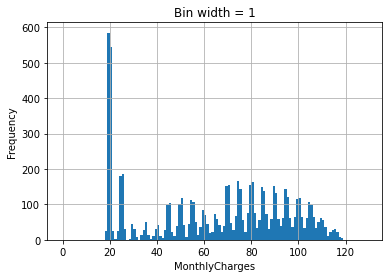

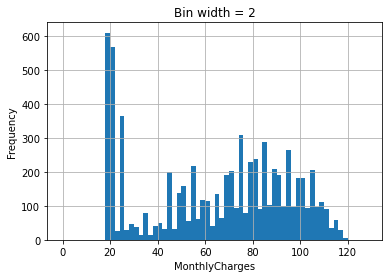

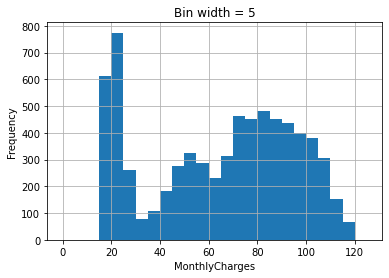

In [2]:
def view_hist(column, bin_width, ranges):
    for ii in bin_width:
        bins = np.arange(*ranges, ii)
        out = orig_data.hist(column=column, bins=bins)
        for ax in out.flatten():
            ax.set_title('Bin width = '+str(ii))
            ax.set_xlabel(column)
            ax.set_ylabel('Frequency')

# Examine histogram at various bin widths:
view_hist('MonthlyCharges', [1, 2, 5], [0, 130]) # bin_width=1 optimal
# view_hist('tenure', [1, 2, 5], [0, 80]) # bin_width=1 optimal
# view_hist('TotalCharges', [100, 200, 500], [0, 9000]) # bin_width=100 optimal

Histogram indicates sensitivity to binning. Bin width need to be small enough to capture variations within numerical attributes. But large enough to minimize the number of bins since they will be encoded as categorical features.

In [3]:
# Create and modify copy of original data:
mod_data = orig_data.copy()

# Apply discretization to the following continuous columns. Values correspond to optimal bin_width.
discrete_map = {
    'tenure': [0, int(np.max(orig_data['tenure'])+1), 1],
    'MonthlyCharges': [0, int(np.max(orig_data['MonthlyCharges'])+1), 1],
    'TotalCharges': [0, int(np.max(orig_data['TotalCharges'])+200), 25]
}

if len(discrete_map) > 0:
    for cc in discrete_map.keys():
        mod_data[cc] = pd.cut(mod_data[cc].astype(int), bins=np.arange(*discrete_map[cc]))
        mod_data[cc] = mod_data[cc].astype(str) # Convert to str for SDV to use

mod_data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,Yes,No,"(0, 1]",No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,"(28, 29]","(25, 50]",False
1,5575-GNVDE,Male,False,No,No,"(33, 34]",Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,"(55, 56]","(1875, 1900]",False
2,3668-QPYBK,Male,False,No,No,"(1, 2]",Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,"(52, 53]","(100, 125]",True
3,7795-CFOCW,Male,False,No,No,"(44, 45]",No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),"(41, 42]","(1825, 1850]",False
4,9237-HQITU,Female,False,No,No,"(1, 2]",Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,"(69, 70]","(150, 175]",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,False,Yes,Yes,"(23, 24]",Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,"(83, 84]","(1975, 2000]",False
7039,2234-XADUH,Female,False,Yes,Yes,"(71, 72]",Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),"(102, 103]","(7350, 7375]",False
7040,4801-JZAZL,Female,False,Yes,Yes,"(10, 11]",No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,"(28, 29]","(325, 350]",False
7041,8361-LTMKD,Male,True,Yes,No,"(3, 4]",Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,"(73, 74]","(300, 325]",True


In [4]:
from sdv.constraints import CustomConstraint

# Create custom constraint for phone service:
def phoneService_xf(table_data, column):
    table_data[column] = table_data[column]
    return(table_data)

def phoneService_rxf(table_data, column):
    noService = table_data.PhoneService=='No'
    table_data.loc[noService, column] = 'No phone service'
    return(table_data)

# def phoneService_validate(table_data, column):
#     valid_mapping = (
#         ((table_data.PhoneService=='Yes') & (table_data[column]!='No phone service')) |
#         ((table_data.PhoneService=='No') & (table_data[column]=='No phone service'))
#               )
#     valid = table_data.loc[valid_mapping]
#     print(valid.tail())
#     return(valid)
    
phoneService_constraint = CustomConstraint(
    columns = ['MultipleLines'], 
    transform = phoneService_xf,
    reverse_transform = phoneService_rxf,
    # is_valid = phoneService_validate
    )

# Constraint via transform/reverse_transform works for PhoneService=='No'. But we can still get 'No phone service' 
# when PhoneService=='Yes' in sythesized data:
# 
# PhoneService  MultipleLines   
# No            No phone service    13318
# Yes           No                  60412
#               Yes                 24537
#               No phone service     1733

# Need to apply rejection criteria after sample created via the "is_valid" interface.
# Upon further inspection, we should be able to implement conditions on PhoneService via "is_valid".



# Create custom constraint for internet service:
def internetService_xf(table_data, column):
    table_data[column] = table_data[column]
    return(table_data)

def internetService_rxf(table_data, column):
    noService = table_data.InternetService=='No'
    table_data[column].loc[noService] = 'No internet service'
    return(table_data)

internetService_constraint = CustomConstraint(
    columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'], 
    transform = phoneService_xf,
    reverse_transform = phoneService_rxf
    )

# # Create custom constraint for MonthlyCharges since CTGAN has problems with modeling semi-discrete, continuous distributions.
# # It doesn't appear to model enough of the modes in the distribution.
# def monthlyCharges_xf(column_data):
#     base = 2.5 # bin width for resampling
#     return(column_data / base)

# def monthlyCharges_rxf(column_data):
#     base = 2.5 # bin width for resampling
#     return(column_data.round()*base)

# monthlyCharges_constraint = CustomConstraint(
#     columns = ['MonthlyCharges'],
#     transform = monthlyCharges_xf,
#     reverse_transform = monthlyCharges_rxf
# )

In [5]:
%%time

# CTGAN not recognizing major split in churn classes. We should split the data explicitly and build separate data models for each class.
orig_data_grp = orig_data.groupby(label_col)
label_cnt = orig_data_grp[label_col].count()
label_classes = orig_data_grp.groups.keys()

mod_data_grp = mod_data.groupby(label_col)

for cc in label_classes:
    print('Processing '+label_col+'='+str(cc)+'...')
    
    # Update batch_size based on number of samples: https://github.com/sdv-dev/CTGAN/issues/137
    # Tuned manually based on 5163/460=11.22 and 1869/460=4.06. Remaining samples not in batch are dropped. 
    cnt = label_cnt.loc[cc]
    print('  Sample size:', cnt)
    
    if model_type == 'CTGAN':
        model = CTGAN(
            # field_transformers = {'tenure': 'categorical'}, 
            # constraints=[phoneService_constraint, internetService_constraint, monthlyCharges_constraint],
            constraints = [phoneService_constraint, internetService_constraint],
            primary_key = 'customerID', 
            # log_frequency = False, # Whether to use log frequency of categorical levels in conditional sampling. Defaults to True.
            embedding_dim = 128, #  Size of the random sample passed to the Generator. Defaults to 128.
            epochs = 500, # default=300. Increments of 10.
            batch_size = 460, # default=500. Increments of 10.
            discriminator_lr = 2e-4, # Learning rate for the discriminator. Defaults to 2e-4.
            # generator_dim = (512, 512, 512), # Defaults to (256, 256).
            # discriminator_dim = (512, 512, 512), # Defaults to (256, 256).
            cuda=True,
            rounding=2
        )
    elif model_type == 'CopulaGAN':
        model = CopulaGAN(
            # field_distributions = {'tenure': 'beta'},
            # field_transformers = {'tenure': 'categorical'}, 
            # constraints=[phoneService_constraint, internetService_constraint, monthlyCharges_constraint],
            constraints = [phoneService_constraint, internetService_constraint],
            primary_key = 'customerID', 
            # log_frequency = False, # Whether to use log frequency of categorical levels in conditional sampling. Defaults to True.
            embedding_dim = 128, #  Size of the random sample passed to the Generator. Defaults to 128.
            epochs = 500, # default=300. Increments of 10.
            batch_size = 460, # default=500. Increments of 10.
            discriminator_lr = 2e-4, # Learning rate for the discriminator. Defaults to 2e-4.
            # generator_dim = (512, 512, 512), # Defaults to (256, 256).
            # discriminator_dim = (512, 512, 512), # Defaults to (256, 256).
            cuda=True,
            rounding=2
        )
    elif model_type == 'TVAE':
        model = TVAE(
            constraints=[phoneService_constraint, internetService_constraint],
            primary_key='customerID', 
            rounding=2
        )
    elif model_type == 'GaussianCopula':
        model = GaussianCopula(
            constraints = [phoneService_constraint, internetService_constraint],
            primary_key = 'customerID', 
            rounding=2
        )
    
    # Fit model:
    model.fit(mod_data_grp.get_group(cc))
    
    # Save model:
    model.save('telco_churn_'+str(cc)+'.pkl')

# TODO: Possible modification to split based on Churn class, then train on separate GPUs.
# cuda (bool or str): If True, use CUDA. If a str, use the indicated device. If False, do not use cuda at all.

Processing Churn=False...
  Sample size: 5163


/home/btong/miniconda3/envs/sdv-dev/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/btong/miniconda3/envs/sdv-dev/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The number of calls to function has reached maxfev = 600.
  warnings.warn(msg, RuntimeWarning)
/home/btong/miniconda3/envs/sdv-dev/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:5003: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
/home/btong/miniconda3/envs/sdv-dev/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2494: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/home/btong/miniconda3/envs/sdv-dev/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing t

Processing Churn=True...
  Sample size: 1869


/home/btong/miniconda3/envs/sdv-dev/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The number of calls to function has reached maxfev = 600.
  warnings.warn(msg, RuntimeWarning)
/home/btong/miniconda3/envs/sdv-dev/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:5003: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
/home/btong/miniconda3/envs/sdv-dev/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2494: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/home/btong/miniconda3/envs/sdv-dev/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/btong/miniconda3/envs/sdv-dev/lib/python3.8/site-packages/sklearn/mixture/_base.py:147: Con

CPU times: user 2min 39s, sys: 14.8 s, total: 2min 53s
Wall time: 2min 35s


Observations:
- CTGAN training not currently reproducible. Variation in quality of model produced with same input parameters.
    - Try increasing epoch and adjust learning rates
    - Useful concepts for tuning GANs from image analysis: https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b
- Distribution for each column assumed to be the same regardless of sub-classes (e.g., split on Churn col)
    - Tenure column distribution is decaying exponential for Churn=True and U-shaped for Churn=False
    - Recommend splitting data based on Churn column and generating a data model for each sub-class. 
        - May also want to examine consistency of distribution shape within major splits (as identified by SHAP, clustering, etc.)
    - Only univariate copulas are currently used in CopulaGAN. A multivariate approach may provide a better fit.
    - Docs for copulas: https://sdv.dev/Copulas/tutorials/01_Introduction_to_Copulas.html. 
        - Used GaussianCopula to generate good match with numerical distributions. However, categorical column composition behaved poorly. Although model called GaussianCopula, other distributions were observed (e.g., beta, gamma, etc.). All distributions were univariate class.
- TODO: train multiple models and determine model that generates best fit against original data distributions
    - Should use hyperparam tuning to discover optimal settings
    - Categorical class distributions within say 10% of original data
    - Post-processing to ensure numerical features are similar in distribution to original data

In [6]:
%%time

def gen_class_samples(label, N_samp):
    """
    Load CTGAN model for a specific Churn class. Generate synthetic samples and output results.
    
    N_samp: int
        Number of samples
        
    label: str
        Label name for class within label_col.
    """
    
    # CTGAN docs: https://sdv.dev/SDV/user_guides/single_table/ctgan.html
    sdv_model = sdv.SDV.load('telco_churn_'+str(label)+'.pkl')
    
    # Generate synthetic samples. Over sample by 10% since some samples may fail to satisfy constraints 
    # imposed in manual post-processing. Avoid duplication when resample.
    # TODO: CTGAN sampling is not deterministic. Need to see if it can be modified with random seed.
    sdv_samp = sdv_model.sample(num_rows=int(1.1*N_samp))
    
    # Apply post-processing to remove erroneous records:
    bad_rows = (sdv_samp['PhoneService']=='Yes') & (sdv_samp['MultipleLines']=='No phone service')
    sdv_samp = sdv_samp[~bad_rows].sample(N_samp, random_state=0, replace=True)
    
    # Duplicate records can be drawn with pd.DataFrame.sample(). Assumed that only unique column is customerID.
    return(sdv_samp)

# Load CTGAN model for each label_classes and take N_samp from each set.

# Fraction of original data in each label_col class:
label_frac = dict(label_cnt/len(orig_data))

synth_data = []
for cc in label_classes:
    N = int(np.rint(label_frac[cc]*N_synth))
    synth_data.append(gen_class_samples(cc, N))

# Assemble synthesized data:
# synth_data = pd.concat([gen_class_samples(cc, N_synth) for cc in label_classes])
synth_data = pd.concat(synth_data)

# Shuffle data to mix label_classes:
synth_data = synth_data.sample(frac=1, random_state=0)

# Ensure customerID is unique:
synth_data['customerID'] = np.vectorize(hex)(np.arange(len(synth_data)))

if len(discrete_map) > 0:
    # Undo discretization:
    discrete_map_keys = list(discrete_map.keys())

    for ii in range(len(discrete_map)):
        cur_col = discrete_map_keys[ii]

        # Set new random state per column being regenerated:
        rng = np.random.default_rng(ii) # Set random state

        # # Undo pd.cut() on original data:
        # source_data[cur_col] = orig_data[cur_col]

        # Undo pd.cut() on synthetic data:
        synth_data.loc[:, cur_col] = synth_data[cur_col].apply(lambda x: int(x.split(',')[0][1:]))

        # Add some deterministic randomness back into float fields that were binned:
        if cur_col != 'tenure':
            synth_data.loc[:, cur_col] = synth_data.loc[:, cur_col] + \
                        np.round(discrete_map[cur_col][2]*rng.random(len(synth_data)), 2)
        
synth_data

CPU times: user 6min 30s, sys: 2.31 s, total: 6min 32s
Wall time: 24.6 s


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
669499,0x0,Female,False,No,No,8,Yes,No,DSL,Yes,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,116.51,5956.54,False
741242,0x1,Male,False,Yes,No,68,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,Two year,No,Electronic check,75.95,2782.46,False
250721,0x2,Female,False,No,No,14,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,18.14,1745.36,False
387075,0x3,Male,False,No,No,36,Yes,No,DSL,No,...,No,Yes,Yes,No,Month-to-month,Yes,Electronic check,96.95,4277.30,False
23572,0x4,Male,False,No,No,6,Yes,No,DSL,No,...,No internet service,No,No internet service,Yes,Month-to-month,No,Mailed check,68.31,4890.00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134459,0xf423b,Male,True,No,No,5,Yes,No,Fiber optic,Yes,...,No,No,No,Yes,Month-to-month,No,Electronic check,34.21,2836.83,True
262175,0xf423c,Male,False,No,No,68,Yes,No,DSL,Yes,...,No,Yes,Yes,No,Month-to-month,No,Credit card (automatic),78.25,3590.44,False
253105,0xf423d,Male,False,No,No,68,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,106.69,4106.86,False
308692,0xf423e,Male,False,Yes,Yes,69,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),63.60,3598.58,False


,orig,synth,diff
OnlineSecurity_No,0.497298,0.282886,0.214412
Partner_No,0.517491,0.690761,0.173270
Partner_Yes,0.482509,0.309239,0.173270
DeviceProtection_No,0.439989,0.282945,0.157044
TechSupport_No,0.493743,0.343157,0.150586
InternetService_DSL,0.343572,0.483751,0.140179
PaymentMethod_Credit card (automatic),0.216297,0.325059,0.108762
InternetService_Fiber optic,0.440273,0.352385,0.087888
OnlineBackup_No,0.438993,0.351538,0.087455
PhoneService_No,0.096701,0.183496,0.086795


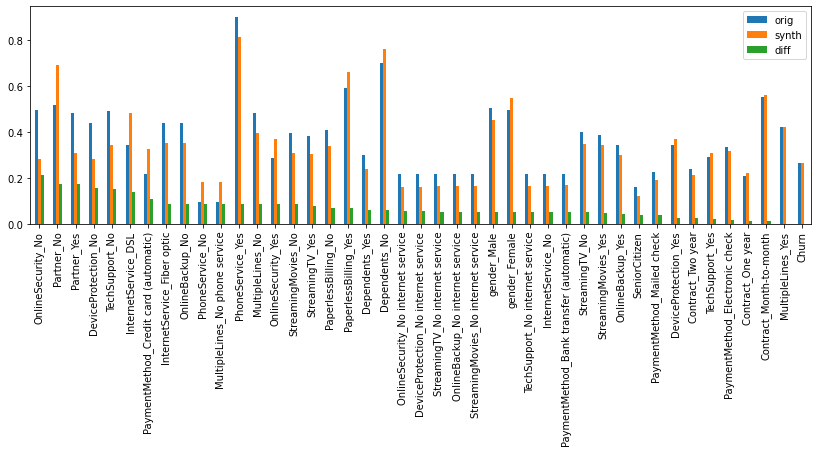

In [7]:
# Compute ratio of categories in each categorical column.
numeric_cols = list(orig_data.select_dtypes('number'))

# Non-numeric cols (e.g., bool, categorical):
cat_cols = sorted(list(set(orig_data.columns) - set(numeric_cols + ['customerID'])))

# Generate table which summarizes categorical distributions:
orig_sm = pd.DataFrame(pd.get_dummies(orig_data[cat_cols]).sum()/len(orig_data), columns=['orig'])
synth_sm = pd.DataFrame(pd.get_dummies(synth_data[cat_cols]).sum()/len(synth_data), columns=['synth'])
cat_sm = orig_sm.join(synth_sm)
cat_sm['diff'] = np.abs(cat_sm['synth'] - cat_sm['orig'])
cat_sm = cat_sm.sort_values('diff', ascending=False)

# Plot:
cat_sm.plot.bar(figsize=(14,4))

cat_sm.head(10)

In [8]:
# Check composition of original data for PhoneService:
print('Original data:')
print(orig_data.groupby('PhoneService')['MultipleLines'].value_counts())
print()

# Check composition of synthetic data for PhoneService:
print('Synthetic data:')
print(synth_data.groupby('PhoneService')['MultipleLines'].value_counts())
print()

# Check data balance after eliminating bad samples:
synth_data['Churn'].value_counts()

Original data:
PhoneService  MultipleLines   
No            No phone service     680
Yes           No                  3385
              Yes                 2967
Name: MultipleLines, dtype: int64

Synthetic data:
PhoneService  MultipleLines   
No            No phone service    183496
Yes           Yes                 421202
              No                  395302
Name: MultipleLines, dtype: int64



False    734215
True     265785
Name: Churn, dtype: int64

### Notes

- CTGAN uses single GPU during training. Mixed CPU/GPU usage observed during sythetic data generation. 
    - Set primary_key within CTGAN() to ensure unique identifiers treated properly. Also appears to train much faster since model is simpler. 
    - Generating 1M samples took ~17s with 25% GPU utilization on single RTX8000. May want to find a way to parallelize fitting/sampling routines. 
- Should be able to feed CTGAN dirty data with missing values and let it generate bad records for subsequent data cleansing
- Constraints can be added to CTGAN to ensure columnar relationships are preserved
    - Expected synth_data to have same data balance as original data. However, after applying constraints, the symmetry appears to be broken. This can be fixed in post-processing.
    - Also appears to impact overall distributions in each feature column since other patterns were associated with the dropped samples
- Evaluation metrics computation are slow. Should only test a handful rather than run sdv.evaluation.evaluate(synth_data, source_data). 
    - May want to just spot check stats externally since some metrics are not designed for millions of records.

# Examine Group Statistics

In [9]:
orig_stats = orig_data.groupby('Churn').describe().T
orig_stats.columns = [str(cc)+' [orig]' for cc in orig_stats.columns]

syth_stats = synth_data.groupby('Churn').describe().T
syth_stats.columns = [str(cc)+' [synth]' for cc in syth_stats.columns]

pd.concat([orig_stats, syth_stats], axis=1).sort_index(axis=1)

False [orig]  False [synth]  True [orig]   True [synth]
tenure         count   5163.000000  734215.000000  1869.000000  265785.000000
               mean      37.650010      36.038253    17.979133      18.140708
               std       24.076940      23.854254    19.531123      20.921320
               min        1.000000       0.000000     1.000000       0.000000
               25%       15.000000      13.000000     2.000000       1.000000
               50%       38.000000      35.000000    10.000000       9.000000
               75%       61.000000      59.000000    29.000000      30.000000
               max       72.000000      71.000000    72.000000      71.000000
MonthlyCharges count   5163.000000  734215.000000  1869.000000  265785.000000
               mean      61.307408      60.850834    74.441332      71.681217
               std       31.094557      29.938758    24.666053      26.152168
               min       18.250000      17.000000    18.850000      17.000000
               25%       25.100000      28.700000    56.150000      50.680000
               50%       64.450000      62.800000    79.650000      75.340000
               75%       88.475000      84.920000    94.200000      94.240000
               max      118.750000     117.990000   118.350000     117.990000
TotalCharges   count   5163.000000  734215.000000  1869.000000  265785.000000
               mean    2555.344141    2462.103187  1531.796094    1856.083852
               std     2329.456984    2289.617139  1890.822994    2060.923107
               min       18.800000       0.000000    18.850000       0.000000
               25%      577.825000     524.090000   134.500000     180.740000
               50%     1683.600000    1712.140000   703.550000    1024.440000
               75%     4264.125000    4077.990000  2331.300000    2962.000000
               max     8672.450000    8674.960000  8684.800000    8699.790000

In [10]:
if model_type in ['CopulaGAN', 'GaussianCopula']:
    from IPython.display import display

    # Examine distributions (only available for CopulaGAN):
    distributions = {}
    for cc in label_classes:
        sdv_model_tmp = sdv.SDV.load('telco_churn_'+str(cc)+'.pkl')
        distributions[label_col + '_' + str(cc)] = pd.Series(sdv_model_tmp.get_distributions())

    distributions = pd.concat(distributions, axis=1)
    display(distributions)

,Churn_False,Churn_True
SeniorCitizen,copulas.univariate.gaussian.GaussianUnivariate,copulas.univariate.gaussian.GaussianUnivariate
Churn,copulas.univariate.beta.BetaUnivariate,copulas.univariate.beta.BetaUnivariate


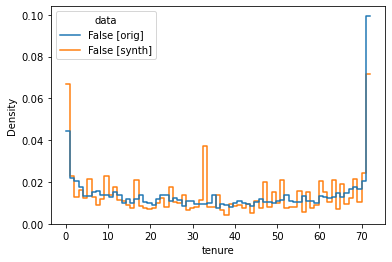

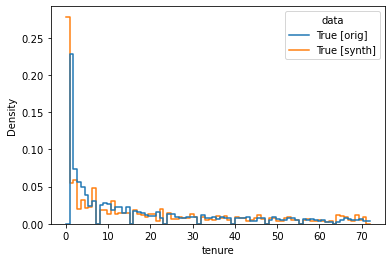

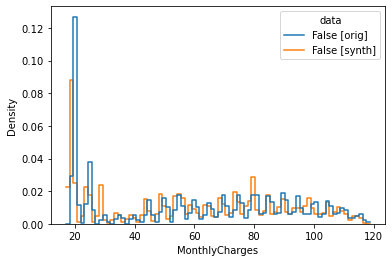

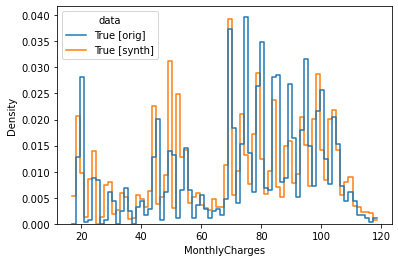

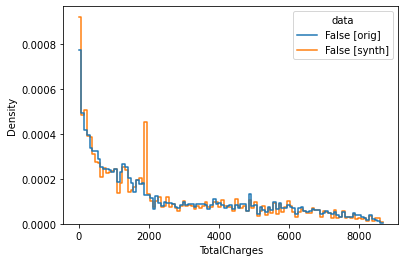

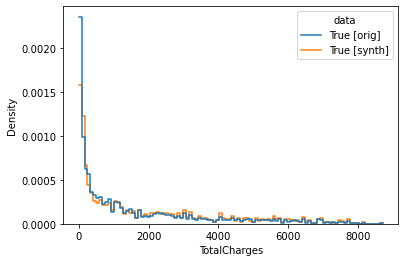

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot normalized distribution of numeric columns:
numeric_cols = list(orig_data.select_dtypes('number').columns)
numeric_cols = numeric_cols + ['Churn']
orig_tmp = orig_data[numeric_cols].copy()
orig_tmp['data'] = orig_tmp['Churn'].astype(str) + ' [orig]'
orig_tmp['source'] = 'orig'

synth_tmp = synth_data[numeric_cols].copy()
synth_tmp['data'] = synth_tmp['Churn'].astype(str) + ' [synth]'
synth_tmp['source'] = 'synth'

numeric_data = orig_tmp.append(synth_tmp)
numeric_data.reset_index(inplace=True)
numeric_data_grp = numeric_data.groupby('Churn')

# common_norm: If True and using a normalized statistic, the normalization will apply over the full dataset. Otherwise, normalize each histogram independently.
for cc in numeric_cols[:-1]:
    for gid, grp in numeric_data_grp:
        plt.figure()
        sns.histplot(data=grp, hue='data', x=cc, element='step', stat='density', fill=False, common_norm=False)
        # sns.kdeplot(data=grp, hue='data', x=cc, common_norm=False) # Smoothed distributions

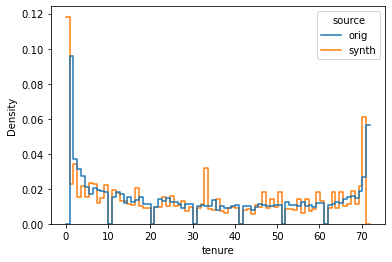

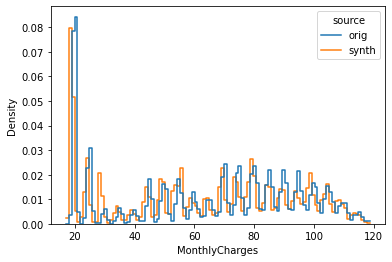

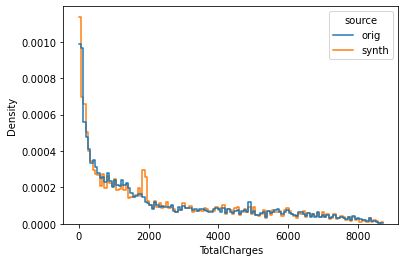

In [12]:
# Examine overall column distributions:
for cc in numeric_cols[:-1]:
    plt.figure()
    sns.histplot(data=numeric_data, hue='source', x=cc, element='step', stat='density', fill=False, common_norm=False)

# Machine Learning Efficacy Score
CTGAN paper suggests using synthetic data to train a variety of ML models. For classification problems, use accuracy and F1 scores to determine model fitness. It also assumed that the data was split into a test/train set to avoid leakage in creating the synthetic model and evaluating it.

For now, visual inspection of the major split in the data (e.g., Churn) is sufficient. If we wanted to evaluate synthetic data generation techniques against one another, then implementing a similar workflow would be needed. 

In [13]:
%%time

from sdv.metrics.tabular import BinaryAdaBoostClassifier

# Only need to drop primary_key column since target column needs to be passed.
attr_cols = [cc for cc in orig_data.columns if cc not in ['customerID']]

# Use built-in methods to evaluate data generation for ML workflows.
# https://sdv.dev/SDV/user_guides/evaluation/single_table_metrics.html#machine-learning-efficacy-metrics
synth_data_score = BinaryAdaBoostClassifier.compute(orig_data[attr_cols], synth_data[attr_cols], target=label_col)

# Compare against ML model built from original data:
train = orig_data[attr_cols].sample(int(len(orig_data) * 0.85), random_state=0)
test = orig_data[attr_cols][~orig_data.index.isin(train.index)]
real_data_score = BinaryAdaBoostClassifier.compute(test, train, target=label_col)

# Check if ML scores are close between real/synth data models.
# TODO: build XGBOOST model using synth data and score it against real data.
print('Real data ML score:', real_data_score)
print('Synthetic data ML score:', synth_data_score)
print()

Real data ML score: 0.5749486652977414
Synthetic data ML score: 0.5723195010793954

CPU times: user 54.6 s, sys: 1.59 s, total: 56.2 s
Wall time: 56.3 s


In [14]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

## OLD Notes
Some of the issues below have already been addressed in revised implementation shown above.

Observed that min/max ranges based on column instead of classes within column. Distributions of numeric attributes for each churn class is not the same between original and synthetic data. 
- Tried to balance data based on Churn class prior to training CTGAN by oversampling
    - Appears to improve observed distributions for minority class. However, CTGAN already accounts for data imbalance internally.
    - When using categorical encoding for MonthlyCharges field, noticed that better match can be obtained by balancing data beforehand. Need to convert bins back to continuous data.
- Some distributions such as MonthlyCharges are too jagged. May need to be pre-conditioned into discrete values instead of continuous due to semi-discrete nature.
    - Possible to simulate with the transform/inverse transform interface? Sparsity concern if modelled as fully discrete since there will be >30 categories in MonthlyCharges.
- Tried to use TVAE. Observed poor distribution matching at head/tail of distributions that are front/tail loaded.
    - See results for the Tenure column
    - Gaussian distribution built into formulation is not applicable in our case
- TODO: Manually split data into handful of groups, then train individual CTGAN models on each subset. May be able to treat each subset as an independent table?
    - This ensures that the split between churn classes are explicitly known. For example, tenure distribution is U-shaped for general population but L-shaped for customer who churn. 

In [ ]:
%%time

from sdv.metrics.tabular import CSTest, KSTest, LogisticDetection, SVCDetection

# # Evaluate data quality:
# sdv.evaluation.evaluate(synth_data, source_data)

SVCDetection.compute(synth_data.sample(10000, random_state=0), orig_data)

# SVCDetection is very slow. Not intended to be used with more than tens of thousands of records. 

In [ ]:
%%time

# Run all available statistical evaluation metrics:
# https://sdv.dev/SDV/user_guides/evaluation/single_table_metrics.html#statistical-metrics
sdv.evaluation.evaluate(synth_data.sample(10000, random_state=0), orig_data, aggregate=False)